In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
#import tensorflow_datasets as tf_datasets
import sklearn
import seaborn as sns
import os
import datetime
import keras

%load_ext tensorboard

/home/wurst/anaconda3/envs/tensorflow/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/wurst/anaconda3/envs/tensorflow/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/wurst/anaconda3/envs/tensorflow/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/wurst/anaconda3/envs/tensorflow

In [2]:
# get the data set
#mnist_builder = tf_datasets.image.mnist.MNIST()
#mnist_builder.download_and_prepare()
#mnist = mnist_builder.as_dataset()
mnist = keras.datasets.mnist.load_data()
#mnist

In [3]:
mnist_X_train = np.array(mnist[0][0]) / 255
mnist_y_train = np.array(mnist[0][1])
mnist_X_test = np.array(mnist[1][0]) / 255
mnist_y_test = np.array(mnist[1][1])

print(mnist_X_train.shape)
print(mnist_y_train.shape)
print(mnist_X_test.shape)
print(mnist_y_test.shape)

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


1.0


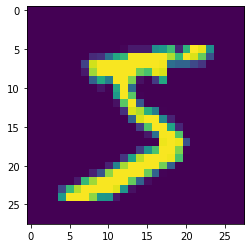

In [4]:
plt.imshow(mnist_X_train[0, :].reshape(28, 28))
print(max(mnist_X_train[0, :, :].reshape(-1)))

In [5]:
encoding_size = 10

In [6]:
logdir = './tb_logs'
tensorboard_callback = keras.callbacks.TensorBoard(logdir, histogram_freq=1)

In [7]:
# Simple dense layer model

enc_input = l = keras.layers.Input(shape=(28, 28))
l = keras.layers.Flatten()(l)
l = keras.layers.Dense(200, activation='relu')(l)
l = keras.layers.Dense(encoding_size, activation='relu')(l)
encoder = keras.models.Model(inputs=enc_input, outputs=l)

dec_input = l = keras.layers.Input(shape=(encoding_size,))
l = keras.layers.Dense(200, activation='relu')(l)
l = keras.layers.Dense(28*28, activation='sigmoid')(l)
l = keras.layers.Reshape(target_shape=(28, 28))(l)
decoder = keras.models.Model(inputs=dec_input, outputs=l)

autocoder = keras.models.Model(inputs=enc_input, outputs=simple_decoder(simple_encoder(enc_input)))

autocoder.compile(optimizer='adadelta', loss='binary_crossentropy')






Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [8]:
autocoder.fit(
    mnist_X_train,
    mnist_X_train,
    epochs=40, 
    batch_size=256,
    shuffle=True, 
    validation_data=(mnist_X_test, mnist_X_test),
    callbacks=[tensorboard_callback]
)


Train on 60000 samples, validate on 10000 samples



Epoch 1/40
60000/60000 [==============================] - 15s 243us/step - loss: 0.3300 - val_loss: 0.2664
Epoch 2/40
60000/60000 [==============================] - 14s 233us/step - loss: 0.2602 - val_loss: 0.2508
Epoch 3/40
60000/60000 [==============================] - 14s 235us/step - loss: 0.2422 - val_loss: 0.2300
Epoch 4/40
60000/60000 [==============================] - 14s 234us/step - loss: 0.2217 - val_loss: 0.2142
Epoch 5/40
60000/60000 [==============================] - 14s 233us/step - loss: 0.2091 - val_loss: 0.2034
Epoch 6/40
60000/60000 [==============================] - 14s 237us/step - loss: 0.1990 - val_loss: 0.1923
Epoch 7/40
60000/60000 [==============================] - 14s 237us/step - loss: 0.1877 - val_loss: 0.1828
Epoch 8/40
60000/60000 [==============================] - 14s 241us/step - loss: 0.1809 - val_loss: 0.1780
Epoch 9/40
60000/60000 [==============================] - 14s 234us/step - loss: 0.1763 - 

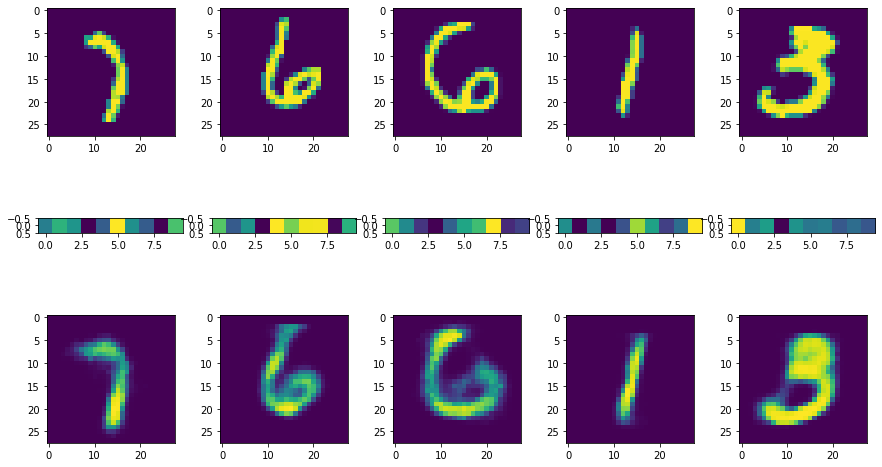

In [11]:
plt.figure(figsize=(15, 8))

n = 5

for i, j in zip(range(n), np.random.randint(0, 10000, size=n)):
    original = mnist_X_test[j, :]
    encoded = encoder.predict(original.reshape(1, 28, 28))[0]
    decoded = decoder.predict(encoded.reshape(1, -1))[0]
    
    plt.subplot(3, n, i+1)
    plt.imshow(original)
    
    plt.subplot(3, n, i+n+1)
    plt.imshow(encoded.reshape(1, -1))

    plt.subplot(3, n, i+n+n+1)
    plt.imshow(decoded)

In [23]:
import sklearn.decomposition

# Compute PCA
encoded_train_images = encoder.predict(mnist_X_train)
encoded_test_images = encoder.predict(mnist_X_test)

pca = sklearn.decomposition.PCA(n_components=encoding_size)
pca.fit(encoded_train_images)

pca_train_images = pca.transform(encoded_train_images)

minmax = sklearn.preprocessing.MinMaxScaler()
minmax.fit(pca_train_images)

MinMaxScaler(copy=True, feature_range=(0, 1))

In [26]:
import ipywidgets

def draw_pca(x1, x2, x3, x4, x5, x6, x7, x8, x9, x10):
    vec = np.array([x1, x2, x3, x4, x5, x6, x7, x8, x9, x10]).reshape(1, -1)
    plt.imshow(decoder.predict(pca.inverse_transform(minmax.inverse_transform(vec))).reshape(28, 28))

ipywidgets.interact(draw_pca, 
         x1=ipywidgets.FloatSlider(min=-1, max=1, step=0.01, continuous_update=False),
         x2=ipywidgets.FloatSlider(min=-1, max=1, step=0.01, continuous_update=False),
         x3=ipywidgets.FloatSlider(min=-1, max=1, step=0.01, continuous_update=False),
         x4=ipywidgets.FloatSlider(min=-1, max=1, step=0.01, continuous_update=False),
         x5=ipywidgets.FloatSlider(min=-1, max=1, step=0.01, continuous_update=False),
         x6=ipywidgets.FloatSlider(min=-1, max=1, step=0.01, continuous_update=False),
         x7=ipywidgets.FloatSlider(min=-1, max=1, step=0.01, continuous_update=False),
         x8=ipywidgets.FloatSlider(min=-1, max=1, step=0.01, continuous_update=False),
         x9=ipywidgets.FloatSlider(min=-1, max=1, step=0.01, continuous_update=False),
         x10=ipywidgets.FloatSlider(min=-1, max=1, step=0.01, continuous_update=False));

interactive(children=(FloatSlider(value=0.0, continuous_update=False, description='x1', max=1.0, min=-1.0, ste…

In [ ]:
v = encoded_train_images[2]
v

In [ ]:
v2 = pca.transform(v.reshape(1, -1))
v2

In [ ]:
plt.imshow(decoder.predict(pca.inverse_transform(v2))[0])